Bộ dữ liệu: So sánh thời gian sử dụng mạng xã hội của Nam giữa hai lứa tuổi từ 18-20 và từ 21-23. Nhận xét trung bình thời gian của hai lứa tuổi, càng lớn tuổi thời gian sử dụng mạng xã hội càng ít hơn không ?

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize,stats
#from summarytools import dfSummary
from scipy.stats import norm, chi2

In [11]:
# Đọc dữ liệu
df = pd.read_csv('Book1.csv')
X = df['X'].values
Y = df['Y'].values
n = len(X)
df.head()

,X,Y
0,5.3,2.9
1,5.5,6.0
2,4.9,5.1
3,6.1,4.7
4,5.3,4.3


In [12]:
# Thống kê mô tả cơ bản cho toàn bộ DataFrame
Avg_X = np.mean(X)      # Trung bình cộng của X
Avg_Y = np.mean(Y)      # Trung bình cộng của Y
s_1 = np.sqrt(np.var(X, ddof=1))      # Độ lệch chuẩn mẫu của X
s_2 = np.sqrt(np.var(Y, ddof=1))      # Độ lệch chuẩn mẫu của Y
n_1 = len(X)     # Số lượng phần tử X
n_2 = len(Y)     # Số lượng phần tử Y
print("Thống kê mô tả chung:")
print(df.describe())  # count (số lượng), mean (trung bình), std (độ lệch chuẩn), 

# Một số thống kê bổ sung
print("\nCác thống kê bổ sung:")
print("Skewness X:", stats.skew(X))       # Đo độ lệch (độ bất đối xứng) của phân phối (lệch trái(<0), lệch phải (>0))
print("Kurtosis X:", stats.kurtosis(X))   # Đo độ nhọn (có nhiều giá trị cực biên hay không) (nhọn hơn (>0), bằng hơn (<0))
print("Skewness Y:", stats.skew(Y))
print("Kurtosis Y:", stats.kurtosis(Y))

# Ma trận tương quan
print("\nMa trận hệ số tương quan mẫu:")  # Kiểm tra nên dùng hồi quy hay không
print(df.corr())

Thống kê mô tả chung:
               X          Y
count  56.000000  56.000000
mean    5.092857   4.335714
std     0.879433   0.811156
min     3.000000   2.400000
25%     4.500000   3.875000
50%     4.900000   4.300000
75%     5.600000   4.800000
max     7.200000   6.000000

Các thống kê bổ sung:
Skewness X: 0.2568854591412749
Kurtosis X: -0.13194694936593887
Skewness Y: -0.10875752677214345
Kurtosis Y: -0.05854296627195499

Ma trận hệ số tương quan mẫu:
          X         Y
X  1.000000  0.003423
Y  0.003423  1.000000


Khoảng đoạn bằng nhau

In [ ]:

# Số khoảng (số lớp)
k = 10
if k < 2: ## Không cho phép k < 2 (vì histogram luôn cần ≥ 2 bins)
    k = 2
if k > len(X): ## Không cho phép k > số điểm dữ liệu (vì như vậy nhiều bin sẽ rỗng)
    k = len(X)  # không để k lớn hơn số điểm dữ liệu

def class_frequency_table_equal_count(X, var_name="X", k=10): ## Chia dữ liệu X thành k khoảng (bins) sao cho mỗi khoảng chứa số lượng điểm gần bằng nhau
    n = len(X)
    
    # ==== CHỈNH SỬA CHÍNH Ở ĐÂY: dùng phân vị thực tế của dữ liệu ====
    # Tính các ngưỡng sao cho mỗi khoảng chứa đúng (hoặc gần đúng) n/k quan sát
    percentiles = np.linspace(0, 100, k + 1)        # 0%, 10%, 20%, ..., 100%
    a = np.percentile(X, percentiles)               # Đây chính là các biên thực tế
    
    # Điều chỉnh biên đầu và cuối để histogram hoạt động đúng
    a[0] = -np.inf      # khoảng đầu tiên: (-∞, a1]
    a[-1] = np.inf      # khoảng cuối cùng: (a_{k-1}, +∞]
    
    # Để tránh lỗi khi có giá trị trùng nhau hoàn toàn (rất hiếm)
    a = np.unique(a)    # loại bỏ các biên trùng nếu có
    if len(a) < k + 1:
        # Nếu dữ liệu có quá nhiều giá trị giống nhau → vẫn ép chia đều nhất có thể
        a = np.linspace(X.min() - 1e-9, X.max() + 1e-9, k + 1)

    # Tính tần số thực tế rơi vào từng khoảng
    freq, _ = np.histogram(X, bins=a)
    
    # Tần suất
    rel_freq = freq / n
    
    # Tạo chuỗi mô tả khoảng đẹp mắt
    intervals = []
    for i in range(len(freq)):
        left = "-∞" if np.isneginf(a[i]) else f"{a[i]:.4f}"
        right = "+∞" if np.isposinf(a[i+1]) else f"{a[i+1]:.4f}"
        intervals.append(f"({left}, {right}]")

    # Tạo bảng kết quả
    table = pd.DataFrame({
        "Khoảng": intervals,
        "Biên dưới": a[:-1],
        "Biên trên": a[1:],
        "Tần số": freq.astype(int),
        "Tần suất": rel_freq.round(4),
        "Tần suất (%)": (rel_freq * 100).round(2)
    })

    print(f"\n=== BẢNG TẦN SỐ GHÉP LỚP – CHIA ĐỀU THEO SỐ LƯỢNG ({var_name}) ===")
    print(f"Số mẫu: n = {n} | Số khoảng: k = {k} | Mỗi khoảng ≈ {n//k} quan sát\n")
    display(table.style.format({"Biên dưới": "{:.4f}", "Biên trên": "{:.4f}"}))
    
    return table

# ====================== SỬ DỤNG ======================
# Thay thế hoàn toàn hàm cũ bằng hàm mới này
table_X = class_frequency_table_equal_count(X, "X", k=10)
table_Y = class_frequency_table_equal_count(Y, "Y", k=10) 



=== BẢNG TẦN SỐ GHÉP LỚP – CHIA ĐỀU THEO SỐ LƯỢNG (X) ===
Số mẫu: n = 56 | Số khoảng: k = 10 | Mỗi khoảng ≈ 5 quan sát



,Khoảng,Biên dưới,Biên trên,Tần số,Tần suất,Tần suất (%)
0,"(-∞, 4.0500]",-inf,4.0500,6,0.107100,10.710000
1,"(4.0500, 4.5000]",4.0500,4.5000,5,0.089300,8.930000
2,"(4.5000, 4.6000]",4.5000,4.6000,4,0.071400,7.140000
3,"(4.6000, 4.7000]",4.6000,4.7000,3,0.053600,5.360000
4,"(4.7000, 4.9000]",4.7000,4.9000,7,0.125000,12.500000
5,"(4.9000, 5.3000]",4.9000,5.3000,6,0.107100,10.710000
6,"(5.3000, 5.5000]",5.3000,5.5000,6,0.107100,10.710000
7,"(5.5000, 5.7000]",5.5000,5.7000,6,0.107100,10.710000
8,"(5.7000, 6.4500]",5.7000,6.4500,7,0.125000,12.500000
9,"(6.4500, +∞]",6.4500,inf,6,0.107100,10.710000



=== BẢNG TẦN SỐ GHÉP LỚP – CHIA ĐỀU THEO SỐ LƯỢNG (Y) ===
Số mẫu: n = 56 | Số khoảng: k = 10 | Mỗi khoảng ≈ 5 quan sát



,Khoảng,Biên dưới,Biên trên,Tần số,Tần suất,Tần suất (%)
0,"(-∞, 3.4500]",-inf,3.4500,6,0.107100,10.710000
1,"(3.4500, 3.7000]",3.4500,3.7000,4,0.071400,7.140000
2,"(3.7000, 3.9500]",3.7000,3.9500,7,0.125000,12.500000
3,"(3.9500, 4.2000]",3.9500,4.2000,5,0.089300,8.930000
4,"(4.2000, 4.3000]",4.2000,4.3000,3,0.053600,5.360000
5,"(4.3000, 4.5000]",4.3000,4.5000,7,0.125000,12.500000
6,"(4.5000, 4.7000]",4.5000,4.7000,6,0.107100,10.710000
7,"(4.7000, 5.0000]",4.7000,5.0000,6,0.107100,10.710000
8,"(5.0000, 5.4500]",5.0000,5.4500,6,0.107100,10.710000
9,"(5.4500, +∞]",5.4500,inf,6,0.107100,10.710000


=== BIỂU ĐỒ HISTOGRAM KẾT HỢP ===


/Users/nguyenduchung/miniforge3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7168: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


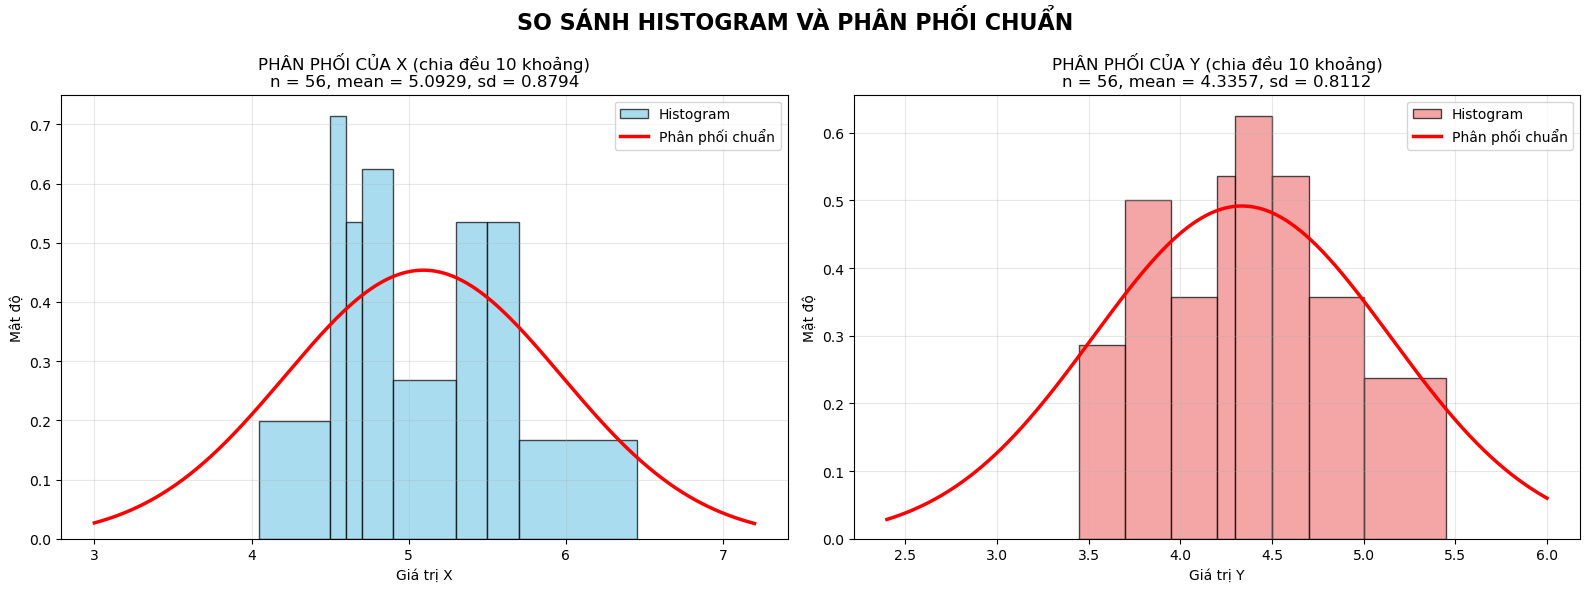

In [14]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_histograms(X, Y, table_X, table_Y):
    """
    Vẽ histogram + đường chuẩn cho X và Y (dùng bảng chia đều theo số lượng)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # === VẼ CHO X ===
    # Lấy biên từ bảng (Biên dưới + giá trị cuối của Biên trên)
    bins_X = np.append(table_X["Biên dưới"].values, table_X["Biên trên"].values[-1])
    
    ax1.hist(X, bins=bins_X, alpha=0.7, color='skyblue', edgecolor='black', density=True, label='Histogram')
    
    # Đường phân phối chuẩn lý thuyết
    mu_X = np.mean(X)
    sigma_X = np.std(X, ddof=1)
    x_val = np.linspace(X.min(), X.max(), 1000)
    ax1.plot(x_val, norm.pdf(x_val, mu_X, sigma_X), 'r-', lw=2.5, label='Phân phối chuẩn')
    
    ax1.set_title(f'PHÂN PHỐI CỦA X (chia đều {len(table_X)} khoảng)\n'
                  f'n = {len(X)}, mean = {mu_X:.4f}, sd = {sigma_X:.4f}', fontsize=12)
    ax1.set_xlabel('Giá trị X')
    ax1.set_ylabel('Mật độ')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # === VẼ CHO Y ===
    bins_Y = np.append(table_Y["Biên dưới"].values, table_Y["Biên trên"].values[-1])
    
    ax2.hist(Y, bins=bins_Y, alpha=0.7, color='lightcoral', edgecolor='black', density=True, label='Histogram')
    
    mu_Y = np.mean(Y)
    sigma_Y = np.std(Y, ddof=1)
    y_val = np.linspace(Y.min(), Y.max(), 1000)
    ax2.plot(y_val, norm.pdf(y_val, mu_Y, sigma_Y), 'r-', lw=2.5, label='Phân phối chuẩn')
    
    ax2.set_title(f'PHÂN PHỐI CỦA Y (chia đều {len(table_Y)} khoảng)\n'
                  f'n = {len(Y)}, mean = {mu_Y:.4f}, sd = {sigma_Y:.4f}', fontsize=12)
    ax2.set_xlabel('Giá trị Y')
    ax2.set_ylabel('Mật độ')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle('SO SÁNH HISTOGRAM VÀ PHÂN PHỐI CHUẨN', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ===================== CHẠY LẠI =====================
print("=== BIỂU ĐỒ HISTOGRAM KẾT HỢP ===")
plot_combined_histograms(X, Y, table_X, table_Y)

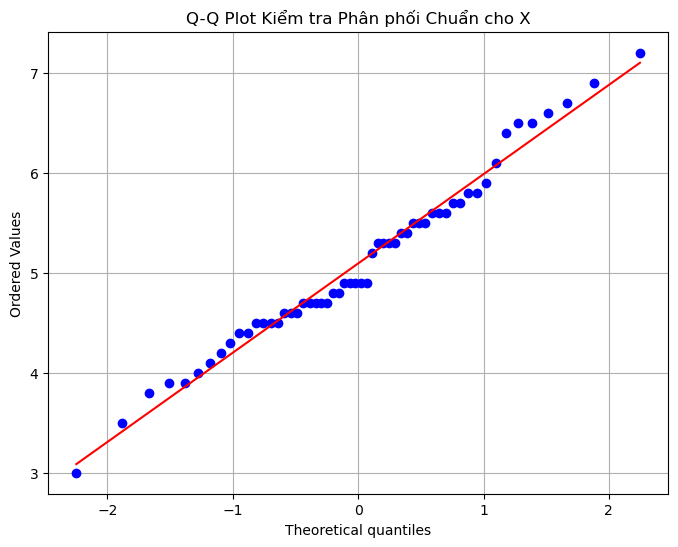

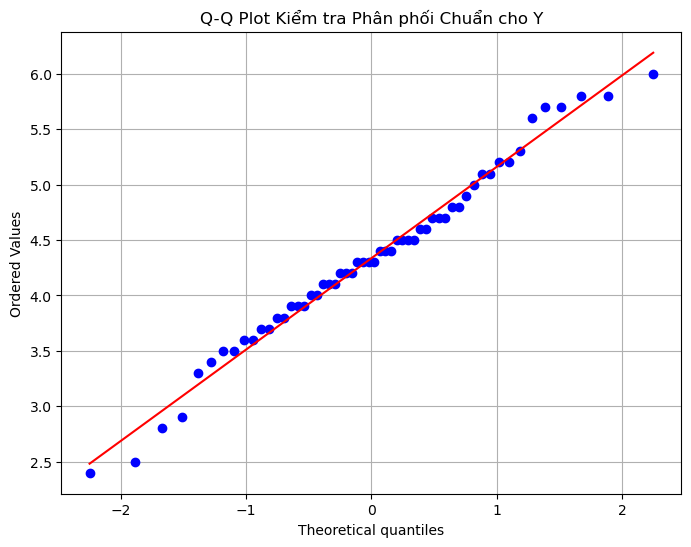

In [15]:
# Q - Q Plot cho X
plt.figure(figsize=(8, 6))
stats.probplot(X, dist="norm", plot=plt) # Hàm probplot tự động thực hiện tất cả các bước trên
plt.title('Q-Q Plot Kiểm tra Phân phối Chuẩn cho X')
plt.grid(True)
plt.show()

# Q - Q Plot cho Y
plt.figure(figsize=(8, 6))
stats.probplot(Y, dist="norm", plot=plt) # Hàm probplot tự động thực hiện tất cả các bước trên
plt.title('Q-Q Plot Kiểm tra Phân phối Chuẩn cho Y')
plt.grid(True)
plt.show()

In [ ]:
def chi2_normality_test(X, var_name="X", alpha=0.05):
    """
    Kiểm định χ² cho tính chuẩn của dữ liệu
    """
    n = len(X)
    
    # Ước lượng tham số chuẩn
    mu_hat = np.mean(X)                   #Lấy trung bình mẫu
    sigma_hat = np.std(X, ddof=1)         #Lấy độ lệch chuẩn mẫu hiệu chỉnh
    
    # Phân vị q_i = i/k
    q = np.linspace(0, 1, k+1)
    a = norm.ppf(q, loc=mu_hat, scale=sigma_hat)
    
    # Điều chỉnh biên đầu -inf và +inf
    a[0] = -np.inf
    a[-1] = np.inf
    
    # Tần số quan sát
    freq_obs, _ = np.histogram(X, bins=a)
    
    # Tần số lý thuyết (dự kiến)
    prob_theoretical = np.diff(norm.cdf(a, loc=mu_hat, scale=sigma_hat))
    freq_exp = prob_theoretical * n
    
    # Đảm bảo tần số dự kiến không quá nhỏ (gộp nhóm nếu cần)
    valid_groups = freq_exp >= 5
    if np.sum(valid_groups) < k:
        print(f"Cảnh báo: Một số nhóm có tần số dự kiến < 5, xem xét giảm số nhóm k")
    
    # Tính χ² cho từng nhóm
    chi2_components = np.where(freq_exp > 0, (freq_obs - freq_exp)**2 / freq_exp, 0)
    
    # Tổng χ²
    chi2_stat = np.sum(chi2_components)
    
    # Bậc tự do (k - 1 - 2) vì ước lượng 2 tham số
    df = k - 1 - 2
    
    # Ngưỡng tới hạn
    critical_value = chi2.ppf(1 - alpha, df)
    
    # Chuỗi mô tả interval
    intervals = []
    for i in range(k):
        left = "-inf" if np.isneginf(a[i]) else f"{a[i]:.4f}"
        right = "+inf" if np.isposinf(a[i+1]) else f"{a[i+1]:.4f}"
        intervals.append(f"({left}, {right}]")
    
    # Tạo bảng kiểm định χ²
    test_table = pd.DataFrame({
        "Khoảng": intervals,
        "a_{i-1}": a[:-1],
        "a_i": a[1:],
        "Tần số quan sát (O_i)": freq_obs,
        "Tần số lý thuyết (E_i)": freq_exp,
        "(O_i - E_i)": freq_obs - freq_exp,
        "(O_i - E_i)²": (freq_obs - freq_exp)**2,
        "(O_i - E_i)²/E_i": chi2_components
    })
    
    # Làm tròn các giá trị
    test_table["Tần số lý thuyết (E_i)"] = test_table["Tần số lý thuyết (E_i)"].round(4)
    test_table["(O_i - E_i)"] = test_table["(O_i - E_i)"].round(4)
    test_table["(O_i - E_i)²"] = test_table["(O_i - E_i)²"].round(4)
    test_table["(O_i - E_i)²/E_i"] = test_table["(O_i - E_i)²/E_i"].round(4)
    
    # Hiển thị kết quả
    print(f"\n{'='*80}")
    print(f"KIỂM ĐỊNH χ² CHO TÍNH CHUẨN CỦA {var_name}")
    print(f"{'='*80}")
    print(f"n = {n}, k = {k}, trung bình mẫu = {mu_hat:.4f}, độ lệch chuẩn mẫu hiệu chỉnh = {sigma_hat:.4f}")
    print(f"Bậc tự do: df = k - 1 - 2 = {k} - 1 - 2 = {df}")
    print(f"\nBẢNG TÍNH TOÁN KIỂM ĐỊNH χ²:")
    display(test_table)
    
    print(f"\nTỔNG HỢP KẾT QUẢ:")
    print(f"χ² quan sát = {chi2_stat:.4f}")
    print(f"Bậc tự do = {df}")
    print(f"Giá trị tới hạn χ²({1-alpha:.2f}, {df}) = {critical_value:.4f}")
    
    # Kết luận
    if chi2_stat > critical_value:
        print(f"KẾT LUẬN: Bác bỏ H₀ → Dữ liệu {var_name} KHÔNG tuân theo phân phối chuẩn")
    else:
        print(f"KẾT LUẬN: Không đủ cơ sở bác bỏ H₀ → Dữ liệu {var_name} tuân theo phân phối chuẩn")
    
    return {
        'test_table': test_table,
        'chi2_stat': chi2_stat,
        'df': df,
        'critical_value': critical_value,
        'conclusion': "Normal" if chi2_stat < critical_value else "Not Normal"
    }

# Thực hiện kiểm định cho X và Y
print("KIỂM ĐỊNH χ² CHO TÍNH CHUẨN")
# Kiểm định cho X
results_X = chi2_normality_test(X, "X")

# Kiểm định cho Y
results_Y = chi2_normality_test(Y, "Y")

# Tóm tắt kết quả
print("\n" + "="*80)
print("TÓM TẮT KẾT QUẢ KIỂM ĐỊNH")
print("="*80)
summary_df = pd.DataFrame({
    'Biến': ['X', 'Y'],
    'n': [len(X), len(Y)],
    'k': [results_X['df'] + 3, results_Y['df'] + 3],
    'Số bậc tự do': [results_X['df'], results_Y['df']],
    'χ² quan sát': [results_X['chi2_stat'], results_Y['chi2_stat']],
    'Giá trị tới hạn': [results_X['critical_value'], results_Y['critical_value']],
    'Kết luận': [results_X['conclusion'], results_Y['conclusion']]
})

display(summary_df)

KIỂM ĐỊNH χ² CHO TÍNH CHUẨN

KIỂM ĐỊNH χ² CHO TÍNH CHUẨN CỦA X
n = 56, k = 10, trung bình mẫu = 5.0929, độ lệch chuẩn mẫu hiệu chỉnh = 0.8794
Bậc tự do: df = k - 1 - 2 = 10 - 1 - 2 = 7

BẢNG TÍNH TOÁN KIỂM ĐỊNH χ²:


,Khoảng,a_{i-1},a_i,Tần số quan sát (O_i),Tần số lý thuyết (E_i),(O_i - E_i),(O_i - E_i)²,(O_i - E_i)²/E_i
0,"(-inf, 3.9658]",-inf,3.965818,5,5.6,-0.6,0.36,0.0643
1,"(3.9658, 4.3527]",3.965818,4.352708,4,5.6,-1.6,2.56,0.4571
2,"(4.3527, 4.6317]",4.352708,4.631682,9,5.6,3.4,11.56,2.0643
3,"(4.6317, 4.8701]",4.631682,4.870055,7,5.6,1.4,1.96,0.3500
4,"(4.8701, 5.0929]",4.870055,5.092857,5,5.6,-0.6,0.36,0.0643
5,"(5.0929, 5.3157]",5.092857,5.315659,5,5.6,-0.6,0.36,0.0643
6,"(5.3157, 5.5540]",5.315659,5.554032,5,5.6,-0.6,0.36,0.0643
7,"(5.5540, 5.8330]",5.554032,5.833007,7,5.6,1.4,1.96,0.3500
8,"(5.8330, 6.2199]",5.833007,6.219896,2,5.6,-3.6,12.96,2.3143
9,"(6.2199, +inf]",6.219896,inf,7,5.6,1.4,1.96,0.3500



TỔNG HỢP KẾT QUẢ:
χ² quan sát = 6.1429
Bậc tự do = 7
Giá trị tới hạn χ²(0.95, 7) = 14.0671
KẾT LUẬN: Không đủ cơ sở bác bỏ H₀ → Dữ liệu X tuân theo phân phối chuẩn

KIỂM ĐỊNH χ² CHO TÍNH CHUẨN CỦA Y
n = 56, k = 10, trung bình mẫu = 4.3357, độ lệch chuẩn mẫu hiệu chỉnh = 0.8112
Bậc tự do: df = k - 1 - 2 = 10 - 1 - 2 = 7

BẢNG TÍNH TOÁN KIỂM ĐỊNH χ²:


,Khoảng,a_{i-1},a_i,Tần số quan sát (O_i),Tần số lý thuyết (E_i),(O_i - E_i),(O_i - E_i)²,(O_i - E_i)²/E_i
0,"(-inf, 3.2962]",-inf,3.296176,4,5.6,-1.6,2.56,0.4571
1,"(3.2962, 3.6530]",3.296176,3.653028,6,5.6,0.4,0.16,0.0286
2,"(3.6530, 3.9103]",3.653028,3.910344,7,5.6,1.4,1.96,0.3500
3,"(3.9103, 4.1302]",3.910344,4.130210,5,5.6,-0.6,0.36,0.0643
4,"(4.1302, 4.3357]",4.130210,4.335714,7,5.6,1.4,1.96,0.3500
5,"(4.3357, 4.5412]",4.335714,4.541218,7,5.6,1.4,1.96,0.3500
6,"(4.5412, 4.7611]",4.541218,4.761085,5,5.6,-0.6,0.36,0.0643
7,"(4.7611, 5.0184]",4.761085,5.018400,4,5.6,-1.6,2.56,0.4571
8,"(5.0184, 5.3753]",5.018400,5.375253,5,5.6,-0.6,0.36,0.0643
9,"(5.3753, +inf]",5.375253,inf,6,5.6,0.4,0.16,0.0286



TỔNG HỢP KẾT QUẢ:
χ² quan sát = 2.2143
Bậc tự do = 7
Giá trị tới hạn χ²(0.95, 7) = 14.0671
KẾT LUẬN: Không đủ cơ sở bác bỏ H₀ → Dữ liệu Y tuân theo phân phối chuẩn

TÓM TẮT KẾT QUẢ KIỂM ĐỊNH


,Biến,n,k,Số bậc tự do,χ² quan sát,Giá trị tới hạn,Kết luận
0,X,56,10,7,6.142857,14.06714,Normal
1,Y,56,10,7,2.214286,14.06714,Normal


KIỂM ĐỊNH GIẢ THUYẾT 

                    KIỂM ĐỊNH GIẢ THUYẾT Z - HAI MẪU LỚN (n1, n2 ≥ 30)
Nhóm 1 (X): n1 = 56,  x̄1 = 5.0929,  s1² = 0.7734
Nhóm 2 (Y): n2 = 56,  x̄2 = 4.3357,  s2² = 0.6580
Δ₀ = 0
H₀: μ1 - μ2 ≤ 0     |     H₁: μ1 - μ2 > 0
Thống kê kiểm định: z₀ = 4.735817
Mức ý nghĩa α = 0.05 → Giá trị tới hạn z_α = 1.6449
Miền bác bỏ W_α = [1.6449, +∞)
p-value = 0.000001
--------------------------------------------------------------------------------


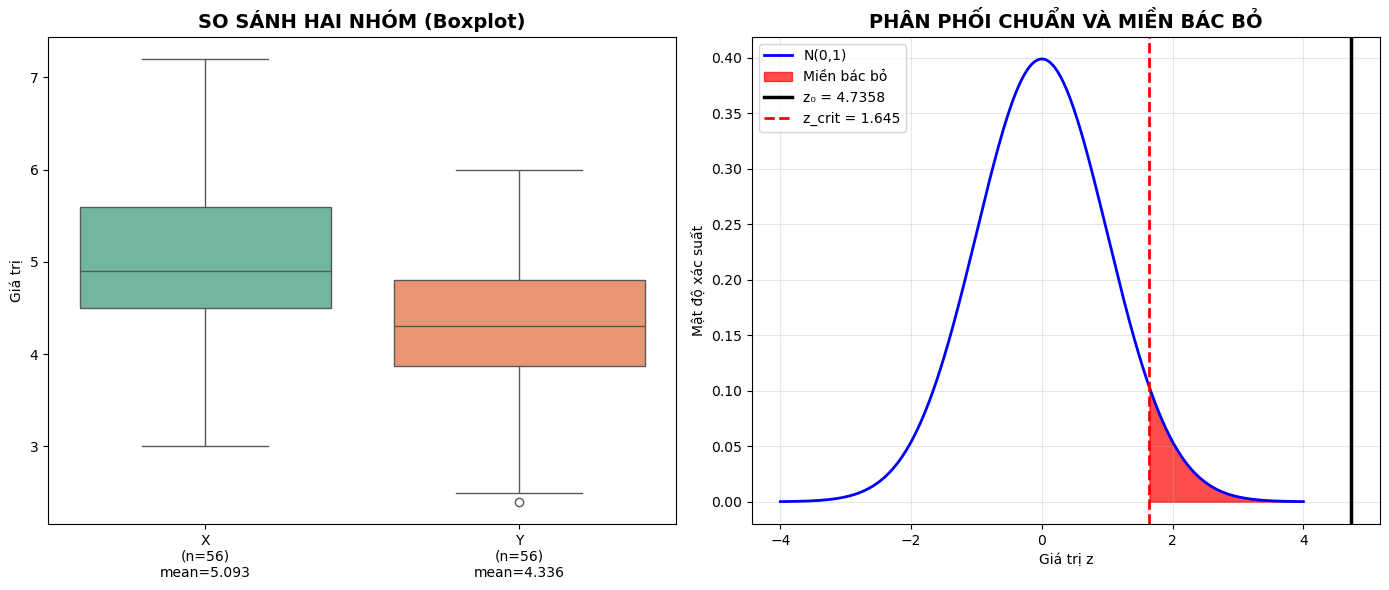

KẾT LUẬN:
   BÁC BỎ H₀ tại mức ý nghĩa α = 0.05 (z₀ nằm trong miền bác bỏ)
   Có cơ sở để chấp nhận H₁: μ1 - μ2 > 0


In [17]:



numeric_cols = df.select_dtypes(include='number').columns.tolist()
if len(numeric_cols) < 2:
    raise ValueError("File cần ít nhất 2 cột số!")

col1 = numeric_cols[0]      # Cột nhóm 1
col2 = numeric_cols[1]      # Cột nhóm 2

X1 = df[col1].dropna().values
X2 = df[col2].dropna().values

n1, n2 = len(X1), len(X2)

if n1 < 30 or n2 < 30:
    print("Cảnh báo: Một trong hai mẫu có kích thước < 30. Với kiểm định Z, nên dùng khi n ≥ 30.")

# ====================== HÀM KIỂM ĐỊNH Z - MẪU LỚN ======================
def kiem_dinh_Z_hai_mau_lon(X1, X2, ten_nhom1, ten_nhom2, 
                           delta_0=0, alpha=0.05, test_type="two-sided"):
    """
    test_type:
        "two-sided" → H1: μ1 ≠ μ2 + Δ₀
        "right"     → H1: μ1 > μ2 + Δ₀  
        "left"      → H1: μ1 < μ2 + Δ₀
    """
    # (1) Xác định dạng giả thuyết
    if test_type == "two-sided":
        h0 = f"μ1 - μ2 = {delta_0}"
        h1 = f"μ1 - μ2 ≠ {delta_0}"
    elif test_type == "right":
        h0 = f"μ1 - μ2 ≤ {delta_0}"
        h1 = f"μ1 - μ2 > {delta_0}"
    elif test_type == "left":
        h0 = f"μ1 - μ2 ≥ {delta_0}"
        h1 = f"μ1 - μ2 < {delta_0}"
    else:
        raise ValueError("test_type chỉ nhận: two-sided, right, left")

    # (4) Tính các giá trị thống kê
    mean1 = np.mean(X1)
    mean2 = np.mean(X2)
    s1_sq = np.var(X1, ddof=1)   # phương sai mẫu hiệu chỉnh nhóm 1
    s2_sq = np.var(X2, ddof=1)   # phương sai mẫu hiệu chỉnh nhóm 2

    # Công thức (31) trong ảnh
    z0 = ( (mean1 - mean2) - delta_0 ) / np.sqrt( s1_sq/n1 + s2_sq/n2 )

    # (2) & (3) Giá trị tới hạn và miền bác bỏ Z ~ N(0,1)
    if test_type == "two-sided":
        z_crit = stats.norm.ppf(1 - alpha/2)        # ví dụ 1.96
        reject_region = f"(-∞, -{z_crit:.4f}] ∪ [{z_crit:.4f}, +∞)"
        p_value = 2 * (1 - stats.norm.cdf(abs(z0)))
    elif test_type == "right":
        z_crit = stats.norm.ppf(1 - alpha)          # ví dụ 1.645
        reject_region = f"[{z_crit:.4f}, +∞)"
        p_value = 1 - stats.norm.cdf(z0)
    elif test_type == "left":
        z_crit = stats.norm.ppf(alpha)              # giá trị âm, ví dụ -1.645
        reject_region = f"(-∞, {z_crit:.4f}]"
        p_value = stats.norm.cdf(z0)

    # (5) Kết luận
    bac_bo = False
    if test_type == "two-sided":
        bac_bo = abs(z0) > z_crit
    elif test_type == "right":
        bac_bo = z0 > z_crit
    elif test_type == "left":
        bac_bo = z0 < z_crit

    # ===================== IN KẾT QUẢ CHI TIẾT =====================
    print("="*80)
    print(" "*20 + "KIỂM ĐỊNH GIẢ THUYẾT Z - HAI MẪU LỚN (n1, n2 ≥ 30)")
    print("="*80)
    print(f"Nhóm 1 ({ten_nhom1}): n1 = {n1},  x̄1 = {mean1:.4f},  s1² = {s1_sq:.4f}")
    print(f"Nhóm 2 ({ten_nhom2}): n2 = {n2},  x̄2 = {mean2:.4f},  s2² = {s2_sq:.4f}")
    print(f"Δ₀ = {delta_0}")
    print(f"H₀: {h0}     |     H₁: {h1}")
    print(f"Thống kê kiểm định: z₀ = {z0:.6f}")
    print(f"Mức ý nghĩa α = {alpha} → Giá trị tới hạn z_α = {z_crit:.4f}")
    print(f"Miền bác bỏ W_α = {reject_region}")
    print(f"p-value = {p_value:.6f}")
    print("-"*80)

    # Vẽ đồ thị
    plt.figure(figsize=(14, 6))

    # Bên trái: Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=[X1, X2], palette=["#66c2a5", "#fc8d62"])
    plt.xticks([0, 1], [f'{ten_nhom1}\n(n={n1})\nmean={mean1:.3f}',
                        f'{ten_nhom2}\n(n={n2})\nmean={mean2:.3f}'])
    plt.title('SO SÁNH HAI NHÓM (Boxplot)', fontsize=14, fontweight='bold')
    plt.ylabel('Giá trị')

    # Bên phải: Phân phối chuẩn + miền bác bỏ
    plt.subplot(1, 2, 2)
    x = np.linspace(-4, 4, 1000)
    y = stats.norm.pdf(x, 0, 1)
    plt.plot(x, y, 'b-', lw=2, label='N(0,1)')

    # Tô màu miền bác bỏ
    if test_type == "two-sided":
        plt.fill_between(x, y, where=(x <= -z_crit), color='red', alpha=0.6)
        plt.fill_between(x, y, where=(x >= z_crit), color='red', alpha=0.6, label='Miền bác bỏ')
    elif test_type == "right":
        plt.fill_between(x, y, where=(x >= z_crit), color='red', alpha=0.7, label='Miền bác bỏ')
    elif test_type == "left":
        plt.fill_between(x, y, where=(x <= z_crit), color='red', alpha=0.7, label='Miền bác bỏ')

    plt.axvline(z0, color='black', linestyle='-', lw=2.5, label=f'z₀ = {z0:.4f}')
    if test_type == "two-sided":
        plt.axvline(-z_crit, color='red', linestyle='--', lw=2)
        plt.axvline(z_crit, color='red', linestyle='--', lw=2,
                    label=f'±z(α/2) = ±{z_crit:.3f}')
    else:
        plt.axvline(z_crit, color='red', linestyle='--', lw=2,
                    label=f'z_crit = {z_crit:.3f}')

    plt.title('PHÂN PHỐI CHUẨN VÀ MIỀN BÁC BỎ', fontsize=14, fontweight='bold')
    plt.xlabel('Giá trị z')
    plt.ylabel('Mật độ xác suất')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Kết luận cuối cùng
    print("KẾT LUẬN:")
    if bac_bo:
        print(f"   BÁC BỎ H₀ tại mức ý nghĩa α = {alpha} (z₀ nằm trong miền bác bỏ)")
        print(f"   Có cơ sở để chấp nhận H₁: {h1}")
    else:
        print(f"   KHÔNG ĐỦ cơ sở để bác bỏ H₀ (z₀ không nằm trong miền bác bỏ)")
        print(f"   Chưa thể kết luận {h1}")

# ===================== CHẠY THỬ =====================
kiem_dinh_Z_hai_mau_lon(
    X1=X1, 
    X2=X2,
    ten_nhom1=col1,
    ten_nhom2=col2,
    delta_0=0,           # Thay đổi tùy ý, ví dụ delta_0=5
    alpha=0.05,
    test_type="right"    # "two-sided", "right", "left"
)